# Food Classification Model
---

**Por:** María Fernanda Moreno Gómez A01708653

Este proyecto tiene como objetivo desarrollar un modelo de clasificación inteligente utilizando PySpark y MLlib sobre un dataset que se caracteriza por su gran volumen de datos. Para este propósito, seleccioné el dataset Food11 obtenido de Kaggle, el cual contiene miles de imágenes distribuidas en 11 categorías de comida:
- **0** Pan (Bread)
- **1** Producto lácteo (Dairy product)
- **2** Postre (Dessert)
- **3** Huevo (Egg)
- **4** Comida frita (Fried food)
- **5** Carne (Meat)
- **6** Fideos-Pasta (Noodles-Pasta)
- **7** Arroz (Rice)
- **8** Mariscos (Seafood)
- **9** Sopa (Soup)
- **10** Vegetales-Frutas (Vegetable-Fruit)

Link del dataset: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset/data

## Preparación del ambiente de trabajo

Como parte del proceso, configuramos el entorno de trabajo en Google Colab para poder trabajar con PySpark, una herramienta esencial para el manejo de grandes volúmenes de datos de manera distribuida. Esto incluye la instalación de dependencias clave como Java y Spark, asegurando así que nuestro entorno esté listo para procesar los datos masivos que provienen de las imágenes del dataset Food11 (porque en verdad, son demasiadas imágenes).



In [1]:
#Bibliotecas para poder trabajar con Spark
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.3//spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz
#Configuración de Spark con Python
!pip install -q findspark
!pip install pyspark

#Estableciendo variable de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

#Buscando e inicializando la instalación de Spark
import findspark
findspark.init()
findspark.find()

#Probando PySparl
from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark = SparkSession \
       .builder \
       .appName("Hola mundo Spark") \
       .getOrCreate()

spark

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,482 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,113 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-upda

## Cargar los datos de mi dataset
---

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Clases (categorías de comida)
classes = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat',
           'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']

# Procesar las carpetas de training, validation y evaluation
train = process_folder(os.path.join(base_dir, 'training'), classes)
validation = process_folder(os.path.join(base_dir, 'validation'), classes)
evaluation = process_folder(os.path.join(base_dir, 'evaluation'), classes)

# Convertir las listas a dense vector
def arr_to_vector(arr):
    return Vectors.dense(arr)

# Hacer el array a un vector denso
arr_to_vector_udf = F.udf(arr_to_vector, VectorUDT())

# Aplicar la conversión en los datasets de training, validation y evaluation
train = train.withColumn('features_vector', arr_to_vector_udf(train['features']))
validation = validation.withColumn('features_vector', arr_to_vector_udf(validation['features']))
evaluation = evaluation.withColumn('features_vector', arr_to_vector_udf(evaluation['features']))

# Mostrar el DataFrame transformado para verificar el cambio
train.show()

## Procesamiento y preparación del dataset
---
El dataset se organiza en tres subconjuntos: entrenamiento (training), validación (validation) y evaluación (evaluation). Cada imagen fue convertida a escala de grises, comprimida a un tamaño de 32x32 píxeles, y luego transformada en un vector de características unidimensional (1D). Este procesamiento es fundamental para reducir la dimensionalidad de las imágenes, facilitando su manejo por el modelo de clasificación que veremos más adelante.

In [3]:
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.types import ArrayType, DoubleType
import pyspark.sql.functions as F
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf, col
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import StringType

# Procesar la imagen
def process_image(image_path):
    # Abrir la imagen original
    img = Image.open(image_path)
    # Capturar el tamaño original
    original_width, original_height = img.size
    # Convertir a escala de grises y redimensionar a 32x32
    img_resized = img.convert('L').resize((32, 32))
    # Convertir la imagen a 1D
    img_array = np.array(img_resized).flatten()
    return img_array, original_width, original_height

# Procesar una carpeta y obtener un dataframe
def process_folder(base_path, classes):
    image_data = []
    for class_label, class_name in enumerate(classes):
        class_dir = os.path.join(base_path, class_name)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            # Procesar la imagen y capturar tamaño original
            img_array, original_width, original_height = process_image(image_path)
            image_data.append(Row(features=img_array.tolist(),
                                  label=class_label,
                                  original_width=original_width,
                                  original_height=original_height))

    # Crear el dataframe de pyspark
    return spark.createDataFrame(image_data)

# Dirección base de mi drive donde está la carpeta madre
base_dir = '/content/drive/MyDrive/Inteligencia Artificial/Inteligencia Artificial 2/Big Data/Food'

# Clases (categorías de comida)
classes = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat',
           'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']

# Procesar las carpetas de training, validation y evaluation
train = process_folder(os.path.join(base_dir, 'training'), classes)
validation = process_folder(os.path.join(base_dir, 'validation'), classes)
evaluation = process_folder(os.path.join(base_dir, 'evaluation'), classes)

# Convertir las listas a dense vector
def arr_to_vector(arr):
    return Vectors.dense(arr)

# Hacer el array a un vector denso
arr_to_vector_udf = F.udf(arr_to_vector, VectorUDT())

# Aplicar la conversión en los datasets de training, validation y evaluation
train = train.withColumn('features_vector', arr_to_vector_udf(train['features']))
validation = validation.withColumn('features_vector', arr_to_vector_udf(validation['features']))
evaluation = evaluation.withColumn('features_vector', arr_to_vector_udf(evaluation['features']))

# Mostrar el DataFrame transformado para verificar el cambio
train.show()

# Seleccionar solo las columnas necesarias para el análisis de tamaño
size_data = train.select("label", "original_width", "original_height")

# Guardar el CSV para analizar la distribución de tamaño en Tableau
size_data_save_path = "/content/drive/MyDrive/Inteligencia Artificial/Inteligencia Artificial 2/Big Data/original_size_data.csv"
size_data.coalesce(1).write.mode('overwrite').option("header", "true").csv(size_data_save_path)

print(f"Original size dataset saved at {size_data_save_path}")


+--------------------+-----+--------------+---------------+--------------------+
|            features|label|original_width|original_height|     features_vector|
+--------------------+-----+--------------+---------------+--------------------+
|[148, 162, 143, 1...|    0|           512|            512|[148.0,162.0,143....|
|[202, 203, 207, 1...|    0|           512|            512|[202.0,203.0,207....|
|[131, 133, 130, 1...|    0|           512|            341|[131.0,133.0,130....|
|[120, 132, 139, 1...|    0|           512|            512|[120.0,132.0,139....|
|[27, 40, 79, 153,...|    0|           341|            512|[27.0,40.0,79.0,1...|
|[44, 47, 38, 38, ...|    0|           512|            512|[44.0,47.0,38.0,3...|
|[21, 22, 32, 92, ...|    0|           512|            512|[21.0,22.0,32.0,9...|
|[9, 6, 7, 8, 8, 9...|    0|           512|            512|[9.0,6.0,7.0,8.0,...|
|[8, 8, 11, 6, 0, ...|    0|           512|            512|[8.0,8.0,11.0,6.0...|
|[14, 9, 19, 29, 2...|    0|

Como podemos observar en el código anterior, las imágenes de su tamaño original se redimensionan a 32 x 32, esto con el propósito de que cuando todas las imágenes tienen un tamaño uniforme, el modelo puede procesarlas de sin tener que hacer cálculos o ajustes para manejar distintas dimensiones. Además, cada pixel de la imagen representa una característica que el modelo debe analizar, por lo que imágenes tan grandes contienen muchas características por analizar que imágenes más pequeñas, por lo que el modelo tardaría más en entrenar (el modelo con estas dimensiones ya tarda unos 15min aprox. en entrenar, entonces no queremos usar más tiempo en esta fase para optimizar los tiempos).

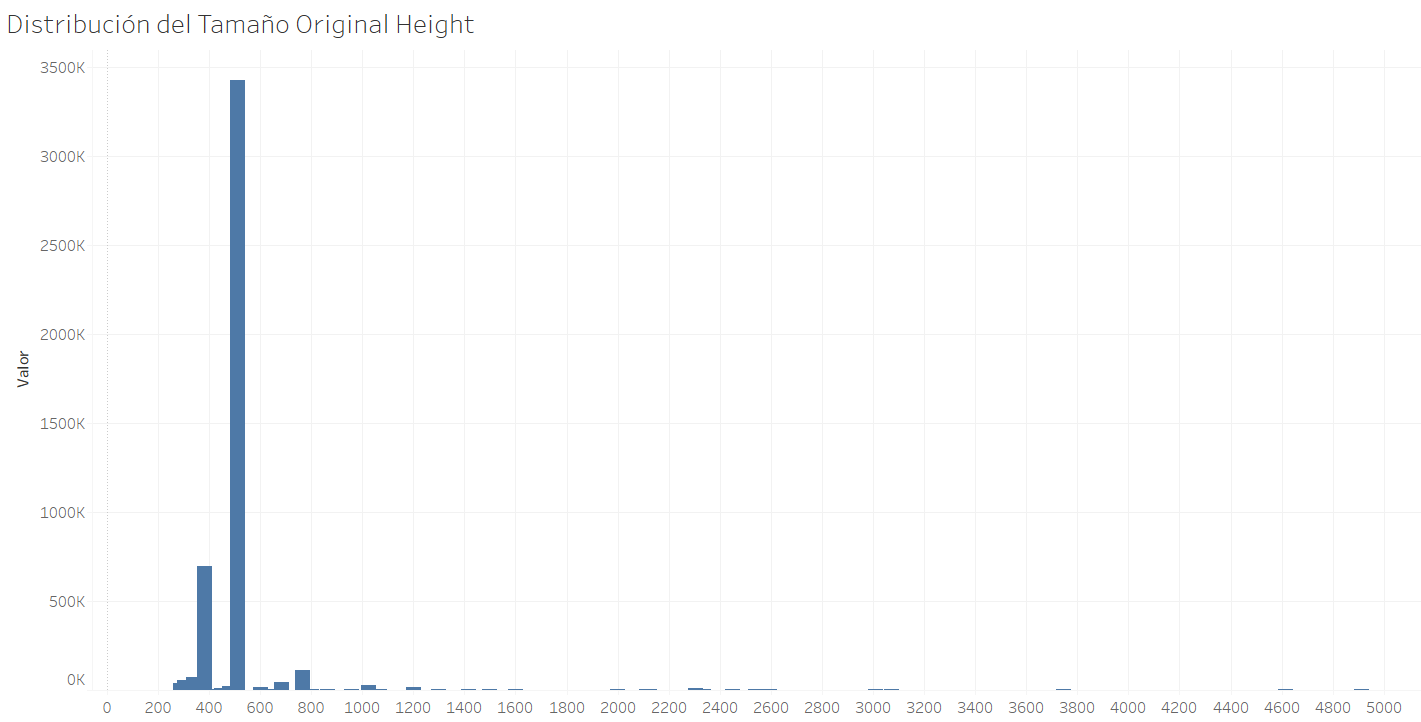

Como podemos observar, en la gráfica de arriba se muestra la distribución del tamaño original de las alturas de todas las imágenes originales con las que fue entrenado el modelo, se muestra que existe una gran variabilidad en la altura original de las imágenes. La mayoría de las imágenes tienen una altura que se conccentra alrededor de valores de 400 px, esta gran variabilidad indica que el conjunto de datos no es muy heterogéneo en términos del tamaño de la altura de las imágenes.

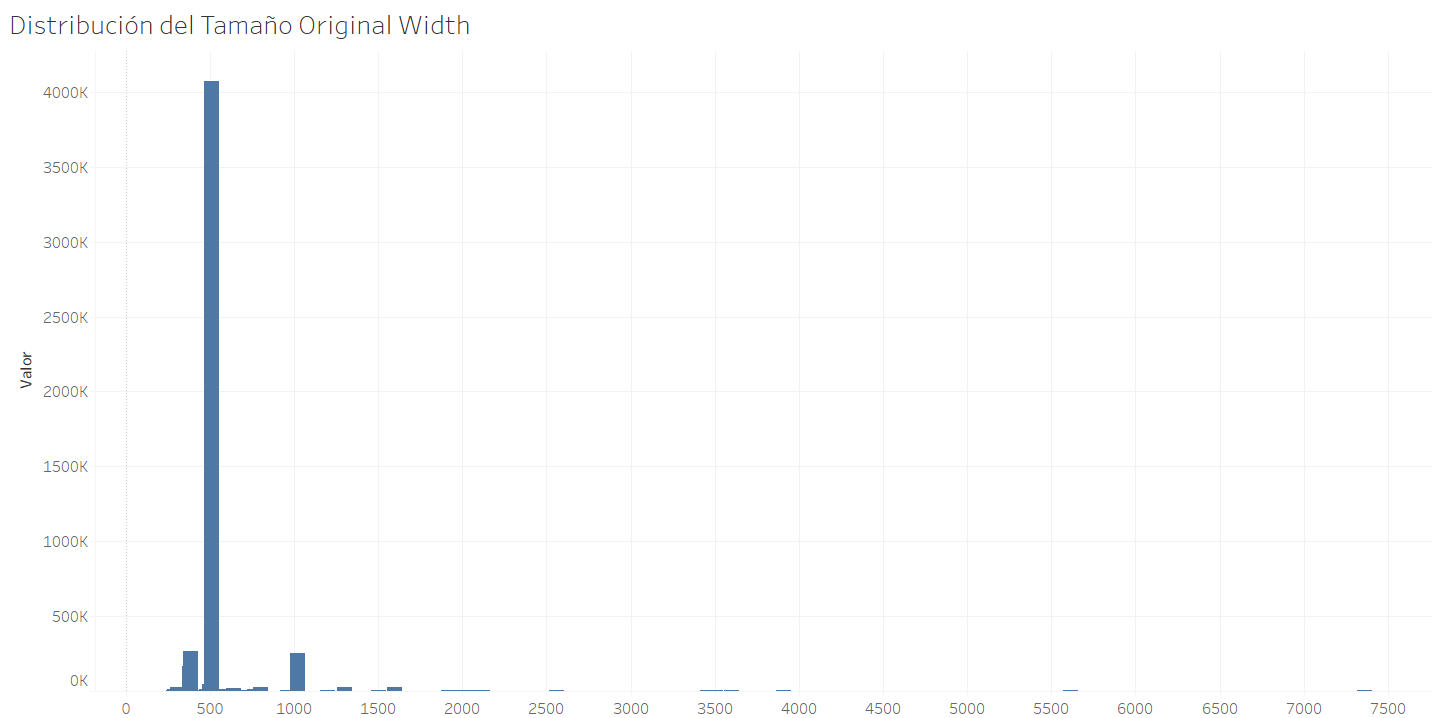

En la gráfica superior podemos observar la distribución del tamaño original del ancho de las imágenes. Al igual que con la distribución de la altura original de las imágenes, el ancho también muestra una gran variabilidad, concentrándose mayormente la mayoría de los anchos alrededor de los 500 px. De igual manera, esta variabilidad implica que unas imágenes ocupan más espacio de memoria que otras debido a su ancho.

Por las razones anteriores, fue que se decidió hacer un resize de las imágenes a 32 x 32 px con el fin de unificar el procesamiento de las imágenes y acortar los tiempos de procesamiento de las imágenes, (pues al trabajar con Big Data de cajón tenemos muchos datos, entonces hay que ver la manera de optimizar su procesamiento). Al hacer el resize, se hizo una gráfica para corroborar que la distribución de la longitud del vector de características tuviera las mismas dimensiones, es decir, 32 x 32 = 1,024, con el fin de verificar que el procesamiento y resize de las imágenes se hizo de manera adecuada.

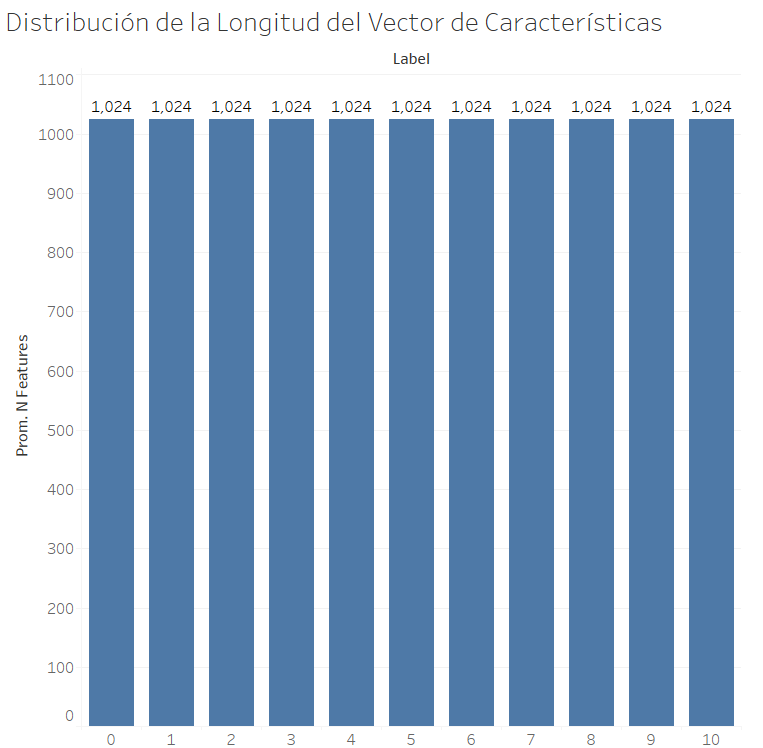

Como podemos observar, en la imagen de la parte superior todas las 11 clases (de la clase 0 a la clase 10) tienen la misma longitud en su vector de características, que es 1,024 por las razones ya comentadas. Con esto en mente, podemos estar seguros que esta fase se hizo de manera correcta y movernos a la creación del modelo de clasificación, teniendo una base sólida en la cual trabajar.

In [4]:
# Hacer un dataset con los metadatos de las imágenes
def extract_metadata(row):
    # Extraer los metadatos
    n_features = len(row['features'])  # Longitud del vector de características
    intensity = float(np.mean(row['features']))  # Intensidad promedio del color
    width = 32  # Ancho en píxeles
    height = 32  # Altura en píxeles

    # Devolver los metadatos como un diccionario
    return Row(label=row['label'], n_features=n_features, intensity=intensity, width=width, height=height)

# Extraer los metadatos de cada fila de train
metadata_rdd = train.rdd.map(extract_metadata)
metadata = spark.createDataFrame(metadata_rdd)

# Mostrar el DataFrame de metadatos para verificar
metadata.show()

# Exportar los metadatos a un CSV
metadata_save_path = "/content/drive/MyDrive/Inteligencia Artificial/Inteligencia Artificial 2/Big Data/train_metadata.csv"
metadata.coalesce(1).write.mode('overwrite').option("header", "true").csv(metadata_save_path)

print(f"Metadata dataset saved at {metadata_save_path}")


+-----+----------+--------------+-----+------+
|label|n_features|     intensity|width|height|
+-----+----------+--------------+-----+------+
|    0|      1024| 158.908203125|   32|    32|
|    0|      1024|134.6611328125|   32|    32|
|    0|      1024|  110.09765625|   32|    32|
|    0|      1024|   142.7109375|   32|    32|
|    0|      1024|  155.18359375|   32|    32|
|    0|      1024|130.7841796875|   32|    32|
|    0|      1024|108.3193359375|   32|    32|
|    0|      1024|112.2822265625|   32|    32|
|    0|      1024| 101.154296875|   32|    32|
|    0|      1024| 136.154296875|   32|    32|
|    0|      1024|   106.4921875|   32|    32|
|    0|      1024|120.4404296875|   32|    32|
|    0|      1024|    117.171875|   32|    32|
|    0|      1024|127.9658203125|   32|    32|
|    0|      1024|  87.111328125|   32|    32|
|    0|      1024|   139.6640625|   32|    32|
|    0|      1024|  125.24609375|   32|    32|
|    0|      1024|  120.95703125|   32|    32|
|    0|      

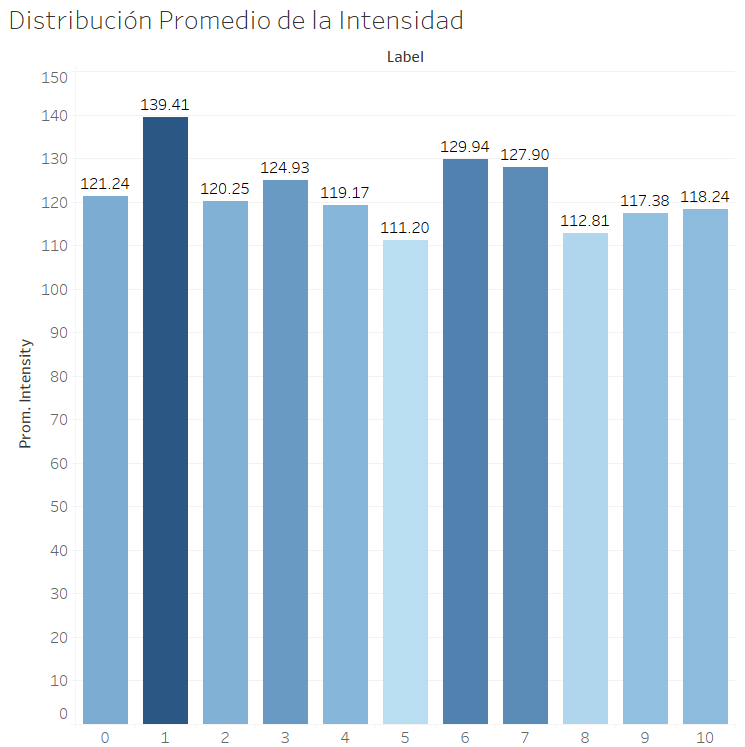

Con los metadatos de las imágenes, hice esta gráfica de la distribución del promedio de la intensidad de los píxeles en escala de grises para cada clase del dataset. La intensidad de un píxel, que varía de 0 (negro) a 255 (blanco), nos proporciona información sobre el brillo promedio de las imágenes en cada clase. Este análisis me permite observar si existen diferencias significativas en los patrones de intensidad entre clases, lo cual podría ser relevante para el modelo al distinguir entre ellas. Si ciertas clases tienen intensidades promedio muy similares, el modelo tal vez podría tener dificultades para diferenciarlas solo con esta característica.

La gráfica muestra que la clase 1 (Productos lácteos) tienen mayor intensidad promedio con un valor de 139.41, mientras que la clase 5 (Carne) tiene la menor con 111.20. Esto indica que, en promedio, las imágenes de la clase "Carne" son más oscuras que las de "Producto lácteo".

Algunas clases como la 9 (Sopa) y la 10 (Vegetales y Frutas) tienen intensidades promedio similares (117.38 y 118.24, respectivamente). Esto podría causar confusión para el modelo, ya que sus patrones de brillo promedio son parecidos.

Aunque hay diferencias, las intensidades promedio están en un rango cercano entre 111 y 140, lo que sugiere que la escala de grises no varía drásticamente entre clases.

In [5]:
# Convertir los features a strings
def convert_string(vector):
    return ','.join([str(value) for value in vector.toArray()])
vector_string = udf(convert_string, StringType())

# Convertir los vectores de features a un string para guardarlos
train_csv = train.withColumn("features_as_string", vector_string(col("features_vector")))

# Seleccionar las features para guardarlas en el csv
train_df_to_be_save = train_csv.select("features_as_string", "label")

# Guardarlo en el path
save_path = "/content/drive/MyDrive/Inteligencia Artificial/Inteligencia Artificial 2/Big Data/train_data.csv"

# Escribir el csv
train_df_to_be_save.coalesce(1).write.mode('overwrite').option("header", "true").csv(save_path)

print(f"Training dataset saved at {save_path}")

Training dataset saved at /content/drive/MyDrive/Inteligencia Artificial/Inteligencia Artificial 2/Big Data/train_data.csv


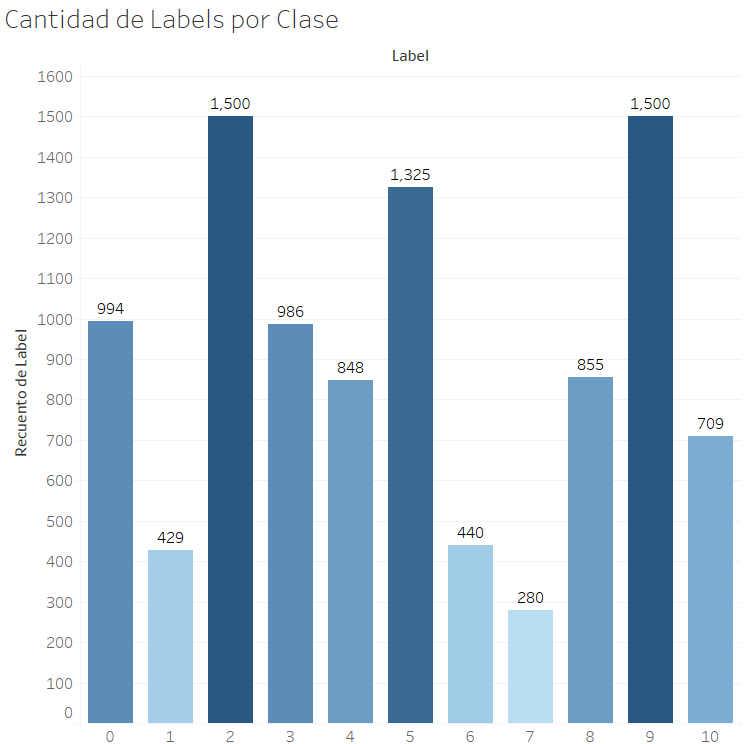

En la presente gráfica está presentada con el fin de analizar la distribución de imágenes en cada clase del dataset. Es importante entender si las clases están balanceadas, ya que un desbalance en los datos puede afectar el rendimiento del modelo. Un modelo de clasificación aprende mejor cuando cada clase tiene una cantidad similar de ejemplos, porque así no prioriza unas clases sobre otras.

La gráfica muestra que:
- Las clases 2 (Postres) y 9 (Sopa) tienen la mayor cantidad de imágenes, con 1,500 ejemplos cada una. Esto sugiere que estas clases estarán mejor representadas en el modelo, y es probable que se clasifiquen con mayor precisión debido a su abundancia de datos.
- La clase 7 (Arroz) tiene la menor cantidad de imágenes, con solo 280 ejemplos, seguida de la clase 1 (Producto lácteo) con 429 imágenes. Estas clases están en desventaja, ya que el modelo tendrá menos datos para aprender patrones de estas categorías, lo que podría llevar a una menor precisión en su clasificación.
- Hay una clara variabilidad en el número de imágenes por clase. Por ejemplo, la clase con más imágenes tiene 1,500 ejemplos, mientras que la clase con menos tiene solo 280 ejemplos. Este desbalance puede influir en que el modelo aprenda mejor las clases mayoritarias y descuide las minoritarias.

En conclusión, la gráfica muestra que el dataset está desbalanceado, lo cual puede afectar negativamente la rendimiento/precisión del modelo. Para mejorar esto y/o evitarlo, se podría hacer aumentaciones en las imágenes de estas clases para mejorar la generalización del modelo.

## Generación del modelo de clasificación
---
El modelo de clasificación que seleccioné fue una Regresión Logística, implementada con la biblioteca de aprendizaje automático de PySpark, MLlib. Este modelo utiliza los vectores de características generados a partir de las imágenes procesadas para entrenar un clasificador que es capaz de predecir la categoría de comida a la que pertenece cada imagen. Posteriormente, el modelo se evaluó utilizando el conjunto de validación para medir su precisión.

In [6]:
# Crear el modelo de regresión logística
logistic_reg = LogisticRegression(featuresCol='features_vector', labelCol='label')

# Entrenar el modelo con el conjunto de entrenamiento
model = logistic_reg.fit(train)

# Hacer predicciones en el conjunto de validación
predictions = model.transform(validation)
predictions.show()


+--------------------+-----+--------------+---------------+--------------------+--------------------+--------------------+----------+
|            features|label|original_width|original_height|     features_vector|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------+---------------+--------------------+--------------------+--------------------+----------+
|[132, 130, 126, 1...|    0|           512|            512|[132.0,130.0,126....|[0.28684543410715...|[0.06891036777655...|       3.0|
|[107, 114, 118, 1...|    0|           384|            512|[107.0,114.0,118....|[0.03222062456348...|[0.07094841910343...|       9.0|
|[131, 135, 142, 1...|    0|           512|            384|[131.0,135.0,142....|[2.62711104206499...|[0.51358019458518...|       0.0|
|[118, 138, 145, 1...|    0|           512|            384|[118.0,138.0,145....|[0.15706107465305...|[0.07217278911029...|       1.0|
|[138, 140, 142, 1...|    0|           512|            512|[13

## Evaluación del modelo
Utilizando las herramientas de evaluación integradas en PySpark, calculamos la precisión del modelo de clasificación y generamos una matriz de confusión para visualizar el rendimiento de nuestro clasificador. Esta matriz de confusión nos permite analizar cuántas predicciones fueron correctas y dónde se encuentran los errores de clasificación.

In [7]:
# Evaluar el modelo usando la precisión
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f"Precisión del modelo: {accuracy}")

Precisión del modelo: 0.17580174927113704


In [8]:
predictions.select("label", "prediction").show(20)


+-----+----------+
|label|prediction|
+-----+----------+
|    0|       3.0|
|    0|       9.0|
|    0|       0.0|
|    0|       1.0|
|    0|       5.0|
|    0|       2.0|
|    0|       0.0|
|    0|       3.0|
|    0|       7.0|
|    0|       2.0|
|    0|       4.0|
|    0|       9.0|
|    0|       5.0|
|    0|       8.0|
|    0|       2.0|
|    0|       5.0|
|    0|       5.0|
|    0|       9.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 20 rows



In [9]:
# Seleccionar las columnas de etiquetas reales y predicciones (para hacer otro csv)
predictions_to_save = predictions.select("label", "prediction")

# Dirección donde se guardará
predictions_save_path = "/content/drive/MyDrive/Inteligencia Artificial/Inteligencia Artificial 2/Big Data/predictions_vs_labels.csv"

# Guardarlo como csv
predictions_to_save.coalesce(1).write.mode('overwrite').option("header", "true").csv(predictions_save_path)

print(f"Predictions and labels dataset saved at {predictions_save_path}")


Predictions and labels dataset saved at /content/drive/MyDrive/Inteligencia Artificial/Inteligencia Artificial 2/Big Data/predictions_vs_labels.csv


In [10]:
# Agrupar por la etiqueta real y la predicción, y contar las ocurrencias
confusion_matrix = predictions.groupBy('label', 'prediction').count()

# Mostrar la matriz de confusión
confusion_matrix.show()
!pip install seaborn matplotlib

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    3|       0.0|   38|
|    2|       9.0|   98|
|    0|       8.0|   22|
|    1|       3.0|   19|
|    4|       0.0|   34|
|    5|       6.0|   13|
|    3|       2.0|   51|
|    4|       6.0|   16|
|    5|       8.0|   27|
|    0|      10.0|   21|
|    1|       9.0|   33|
|    1|       0.0|   18|
|    0|       5.0|   48|
|    4|       9.0|   54|
|    2|      10.0|   28|
|    2|       5.0|   86|
|    1|       7.0|    7|
|    2|       4.0|   30|
|    3|       6.0|    6|
|    2|       8.0|   33|
+-----+----------+-----+
only showing top 20 rows



In [11]:
# Definir el número de épocas para la simulación
num_epochs = 10  # Ajusta este número según lo que necesites

# Lista para almacenar la precisión de cada época
epoch_accuracies = []

# Entrenar y evaluar el modelo en varias epochs
for epoch in range(num_epochs):
    print(f"Entrenando el modelo - Época {epoch + 1}")

    # Crear el modelo de regresión logística
    logistic_reg = LogisticRegression(featuresCol='features_vector', labelCol='label', maxIter=epoch + 1)

    # Entrenar el modelo en el conjunto de entrenamiento
    model = logistic_reg.fit(train)

    # Hacer predicciones en el conjunto de validación
    predictions = model.transform(validation)

    # Evaluar la precisión en el conjunto de validación
    evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
    accuracy = evaluator.evaluate(predictions)

    # Guardar la precisión de esta época en la lista
    epoch_accuracies.append({"epoch": epoch + 1, "accuracy": accuracy})

    print(f"Precisión en la época {epoch + 1}: {accuracy}")

# Convertir los resultados a un df para exportarlo a csv
epoch_accuracies_df = pd.DataFrame(epoch_accuracies)

# Guardar el csv
epoch_accuracies_df.to_csv("/content/drive/MyDrive/Inteligencia Artificial/Inteligencia Artificial 2/Big Data/epoch_accuracies.csv", index=False)

Entrenando el modelo - Época 1
Precisión en la época 1: 0.197667638483965
Entrenando el modelo - Época 2
Precisión en la época 2: 0.1956268221574344
Entrenando el modelo - Época 3
Precisión en la época 3: 0.197667638483965
Entrenando el modelo - Época 4
Precisión en la época 4: 0.2
Entrenando el modelo - Época 5
Precisión en la época 5: 0.19737609329446065
Entrenando el modelo - Época 6
Precisión en la época 6: 0.20349854227405248
Entrenando el modelo - Época 7
Precisión en la época 7: 0.2043731778425656
Entrenando el modelo - Época 8
Precisión en la época 8: 0.20058309037900873
Entrenando el modelo - Época 9
Precisión en la época 9: 0.19650145772594751
Entrenando el modelo - Época 10
Precisión en la época 10: 0.19533527696793002


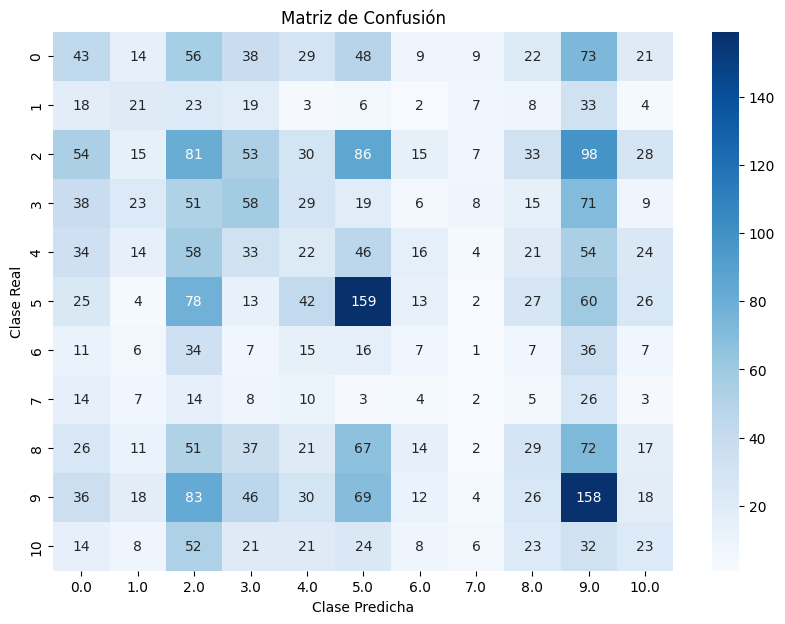

In [12]:
confusion_matrix_pd = confusion_matrix.toPandas()

# Matriz de confusión
confusion_matrix_pivot = confusion_matrix_pd.pivot(index='label', columns='prediction', values='count').fillna(0)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_pivot, annot=True, fmt="g", cmap="Blues")
plt.title("Matriz de Confusión")
plt.ylabel("Clase Real")
plt.xlabel("Clase Predicha")
plt.show()


## Visualización de los resultados en Tableau
---


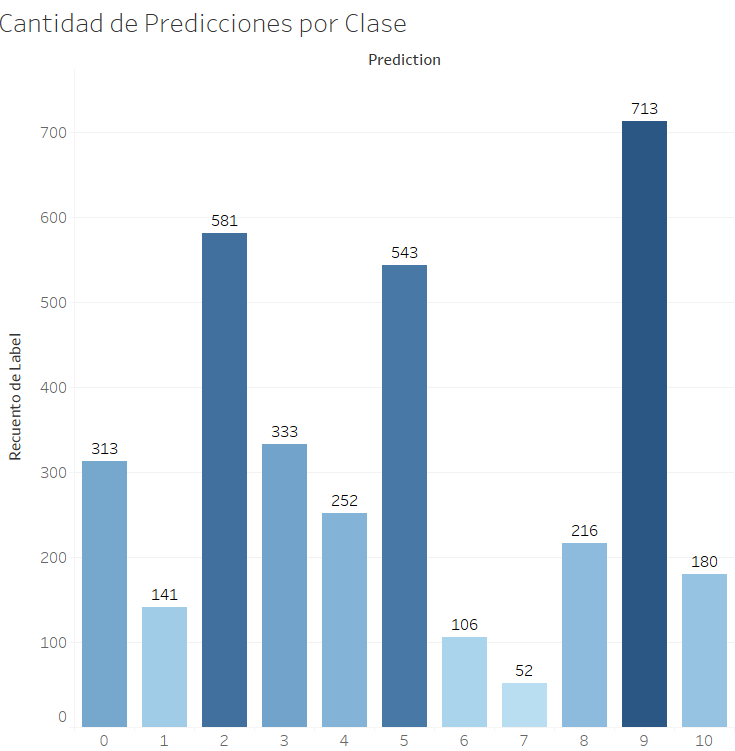

La gráfica de Cantidad de Predicciones por Clase muestra el número de predicciones realizadas por el modelo para cada clase. Su objetivo es analizar cómo el modelo distribuye sus predicciones entre las clases y detectar posibles problemas como sesgos hacia ciertas categorías o dificultades para predecir clases minoritarias.
- La clase 9 (Sopa) tiene la mayor cantidad de predicciones con 713 ejemplos. Esto coincide con que es una de las clases con mayor cantidad de imágenes. Esto tal vez podría indicar un sesgo del modelo hacia esta clase, lo que podría estar relacionado con su alta representación en los datos de entrenamiento.
- La clase 7 (Arroz) tiene la menor cantidad de predicciones con solo 52 ejemplos, seguida de la clase 1 (Producto Lácteo) con 141 ejemplos. Esto de igual manera se puede deber debido al hecho que son las dos clases con menos imágenes en el dataset.
- Al comparar esta gráfica con la de "Cantidad de Labels por Clase", es evidente que el modelo no está prediciendo algunas clases en proporción a su representación real en el dataset. Por ejemplo, aunque la clase 7 (Arroz) ya tenía pocos ejemplos en los datos de entrenamiento, el modelo predice aún menos imágenes de esta clase.
- El modelo claramente está sesgado hacia las clases mayoritarias, como la clase 9, lo que podría estar reduciendo su capacidad de clasificar correctamente las clases minoritarias.
- Las pocas predicciones realizadas para las clases como 7 (Arroz) y 1 (Producto Lácteo) sugieren que el modelo tiene dificultades para identificar correctamente estas categorías. Esto puede deberse a su bajo número de ejemplos en el dataset o a la similitud visual con otras clases.

Posibles soluciones:
- Hacer "data augmentations" para las clases menos representadas, de modo que se tengan más imágenes con las que el modelo pueda entrenar.
- Ajustar los pesos para que a las clases menos representadas, se les de pesos mayores y así equilibrar las predicciones.



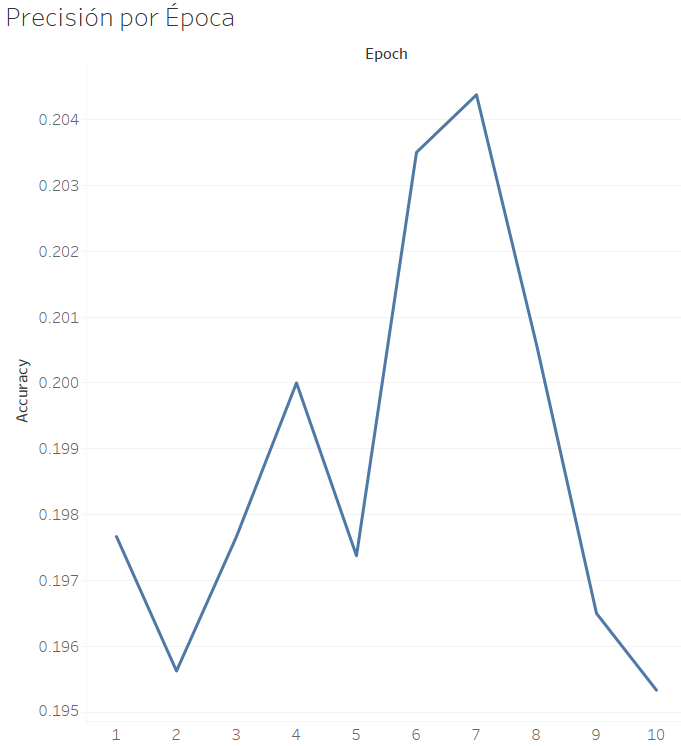

En la gráfica de "Precisión por Época" muestra cómo evoluciona la precisión del modelo en el conjunto de validación a lo largo de las épocas de entrenamiento. El objetivo es analizar el comportamiento del modelo en términos de aprendizaje y detectar posibles problemas como sobreajuste (overfitting) o subajuste (underfitting).

De la gráfica podemos observar que:
- La precisión del modelo no muestra un crecimiento constante; en lugar de eso, fluctúa entre las épocas. Esto podría indicar que el modelo tiene dificultades para optimizar el aprendizaje o que el conjunto de datos presenta desafíos, como un desbalance severo o características no suficientemente representativas.
- La precisión máxima ocurre en la época 7, con un valor de 0.204, pero disminuye drásticamente después de esa época. Esto sugiere que el modelo alcanzó su mejor desempeño alrededor de la época 7, pero no pudo sostenerlo en las épocas posteriores, posiblemente debido a un sobreajuste.
- A partir de la época 7, la precisión cae de manera considerable, llegando a su punto más bajo en la época 10 (0.195). Esto podría indicar que el modelo comienza a memorizar los datos de entrenamiento en lugar de generalizar patrones, lo que lleva a un desempeño decreciente en el conjunto de validación.
- En las primeras épocas, la precisión aumenta gradualmente hasta la época 3-4, lo que indica que el modelo está aprendiendo. Sin embargo, las fluctuaciones constantes muestran que el modelo no logra una convergencia estable.

En conclusión, esta gráfica revela que el modelo tiene dificultades para mantener un desempeño consistente a lo largo de las épocas, alcanzando un pico de precisión seguido de un descenso significativo. Esto puede ser resultado de un sobreajuste o de características poco representativas en los datos. Detener el entrenamiento antes de la época 10 y optimizar el dataset y los hiperparámetros podría mejorar significativamente el desempeño del modelo.


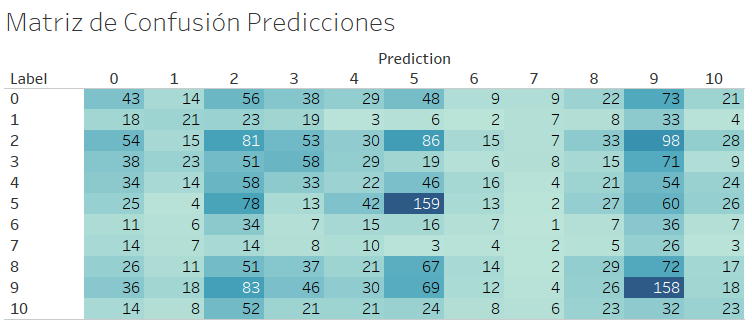

La Matriz de Confusión de las Predicciones hecha en tableau muestra cómo se distribuyen las predicciones del modelo para cada clase. Su objetivo es identificar patrones de error y analizar la capacidad del modelo para distinguir entre clases correctamente. Esta herramienta es crucial para entender si el modelo tiene sesgos o confunde ciertas clases con otras de manera recurrente.

Podemos observar de la matriz que:
- La clase 5 (Carne) tiene el mayor número de predicciones correctas, con 159 aciertos en la diagonal principal. Esto indica que el modelo logró identificar esta clase con relativa precisión. También destacan las clases 9 (Sopa) y 2 (Postres), con 158 y 98 predicciones correctas respectivamente. Estas tres clases coinciden con que son las que más imágenens tienen en el dataset.
- La clase 7 (Arroz) tiene un desempeño muy bajo, con solo 16 predicciones correctas. Esto confirma que el modelo tiene dificultades significativas para identificar esta clase, posiblemente debido al bajo número de ejemplos en el dataset o a su similitud con otras clases. La clase 1 (Producto Lácteo) también tiene pocos aciertos (23), lo que sugiere problemas similares. De manera igual, coincide que son las clases con menores imágenes en su dataset.
- La clase 0 (Pan) se confunde con las clases 9 (Sopa) (73 predicciones) y 4 (Comida Frita) (48 predicciones). Esto puede deberse a patrones visuales similares, como texturas o tonalidades compartidas.
- La clase 2 (Postres) se confunde notablemente con la clase 9 (Sopa) (98 predicciones) y la clase 3 (Huevo) (51 predicciones), lo que podría reflejar similitudes en el contenido visual.


Link para el documento de Tableau: https://drive.google.com/file/d/1-tQPddsjV1r_Gj931OMRcWdskkISg1Fm/view?usp=sharing

Conclusión
---
El modelo mostró un desempeño desigual, con buen rendimiento en clases mayoritarias como Carne y Sopa, pero con dificultades significativas en clases minoritarias como Arroz y Producto Lácteo, debido al desbalance del dataset. Aunque alcanzó su mejor precisión en la época 7, la caída posterior refleja problemas de sobreajuste y falta de generalización. Además, las confusiones entre clases similares, como Pan y Sopa, evidencian la necesidad de características más distintivas.

Para mejorar, sería esencial balancear el dataset, ajustar los pesos de las clases o explorar arquitecturas más adecuadas para el problema que se quiere resolver. Aunque el modelo tiene potencial, necesita ajustes significativos para lograr un desempeño más equilibrado y generalizable.